<center><p style="font-size:30px">Quantum Circuits and Devices / Laboratory 3</p></center>
<center><p style="font-size:30px">Quantum system characterization</p></center>

## Table of Contents <a class="anchor" id="table-of-contents"></a>

1. [Modeling nonideal quantum systems](#nonideal-model)
2. [Rough drive frequency calibration](#rough-calibration)
3. [Precise frequency tuning: Ramsey experiment](#ramsey-experiment)
4. [$T_1$ Characterization: inversion recovery](#inversion-recovery)
5. [$T_2$ Characterization: Hahn ecoes](#hahn-echoes)

In this laboratory, we perform common characterization experiments of a realistic quantum computing system. We will make use of the Qiskit Dynamics extension, that can be installed with the following cell. 

### Requirements and helpers

In [1]:
%pip install qiskit==1.2.4 qiskit-ibm-runtime qiskit_aer qiskit-dynamics
%pip install matplotlib pylatexenc seaborn

from qiskit.quantum_info import Operator, DensityMatrix
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit.circuit import Parameter  
import qiskit.pulse as pulse
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython import display

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

  Using cached requests_ntlm-1.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ibm_platform_services-0.59.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached ibm_cloud_sdk_core-3.22.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.23.4-cp38-cp38-macosx_10_12_x86_64.whl.metadata (6.6 kB)
  Using cached pyspnego-0.11.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached PyJWT-2.9.0-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.6 MB/s eta 0:00:00a 0:00:01
Using cached ibm_platform_services-0.59.0-py3-none-any.whl (340 kB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
Using cached pydantic_core-2.23.4-cp38-cp38-macosx_10_12_x86_64.whl (1.9 MB)
Using cached requests_ntlm-1.3.0-py3-none-any.whl (6.6

## Modeling nonideal quantum systems<a class="anchor" id="nonideal-model"></a>

In the previous laboratory, we considered an idealized two-level qubit model with a perfectly resonant driving field: 

\begin{align}
\frac{\mathcal{H}}{\hbar} = \frac12 \omega \hat{\sigma}_z + \Omega \cos(\omega t)\hat{\sigma}_x
\end{align}

Today, we move towards a more realistic quantum system by considering a two-level qubit model with a near-resonance driving: 
\begin{align}
\frac{\mathcal{H}}{\hbar} = \frac12 \omega \hat{\sigma}_z + \Omega \cos(\omega_d t)\hat{\sigma}_x
\end{align}

Additionally, we include energy relaxation and dephasing effects, which are described by Lindbladian dissipators. The energy relaxation Lindbladian reads: 
\begin{align}
\mathcal{D}_1[\rho] = \Gamma_1\bigg(\hat{\sigma}_+\rho\hat{\sigma}_- - \frac12\{\hat{\sigma}_-\hat{\sigma}_+,\rho\}\bigg)
\end{align}
where $\hat{\sigma}_\pm = \frac12(\hat{\sigma}_x\pm j\hat{\sigma}_y)$ and $\rho$ is the qubit's density matrix. Conversely, the dephasing Lindbladian reads: 
\begin{align}
\mathcal{D}_2[\rho] = \Gamma_2 (\hat{\sigma}_z\rho\hat{\sigma}_z- \rho) 
\end{align}

Overall, the dissipating system is modeled by the Lindblad master equation: 
\begin{align}
\frac{\partial\rho}{\partial t} = -\frac{i}{\hbar}[\mathcal{H},\rho] +\mathcal{D}[\rho]
\end{align}

Lindblad dissipators can be included in a `Solver` object by specifying the additional `static_dissipators` key at construction. In the following, we instantiate the `Solver` for a 4.971852 GHz qubit (same as the `FakeArmonk` backend), a 20 MHz driving field oscillating at 5 GHz (AWG update frequency 4.5 GHz), and dissipation frequencies $\Gamma_1$ = 8 kHz and $\Gamma_2$ = 4 kHz. We then build a corresponding `Backend` from the `Solver` object that will be used in the rest of the laboratory. Notice that, since most of the simulations of this laboratory involve long delays, we enforce a maximum step for the simulations of `200dt`. 

In [4]:
#########################################
# System specifications
#########################################
omega       = 2 * np.pi * 4.971852e9;       # Qubit pulsation [rad/s]
Omega       = 2 * np.pi * 20e6;             # Rabi pulsation at maximum drive [rad/s]
omegad      = 2 * np.pi * 5e9;              # Driving field frequency [rad/s]
Gamma_1     = 8e3;                          # Energy relaxation frequency [Hz]
Gamma_2     = 4e3;                          # Dephasing frequency [Hz]
dt          = 1/(4.5e9);                    # AWG time step [s]

#########################################
# Pauli operators
#########################################
X = Operator.from_label('X'); 
Y = Operator.from_label('Y'); 
Z = Operator.from_label('Z'); 
I = Operator.from_label('I');

#########################################
# Hamiltonians and Lindbladians
#########################################
hdrift  = 1/2 * omega * Z; 
hdrive  = Omega * X;
diss1   = np.sqrt(Gamma_1) * 0.5 * (X + 1j * Y);
diss2   = np.sqrt(Gamma_2) * Z; 

#########################################
# Backend construction
#########################################
solver  = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], hamiltonian_channels=["d0"], rotating_frame=hdrift, channel_carrier_freqs={"d0":omegad/2/np.pi}, dt=dt, static_dissipators=[diss1,diss2]);
backend = DynamicsBackend(solver=solver,solver_options={'max_step':200*dt});

## Frequency calibration

### Coarse drive frequency calibration <a class="anchor" id="rough-calibration"></a>
Up to here, we have always considered the drive field to be perfectly tuned to the qubit frequency. However, this is typically not the case for a first-time setup: while the qubit frequency can be estimated from its design parameters, variability in the fabrication process can lead to slight deviations from the nominal values. As a consequence of this _detuning_, the rotating frame underneath the qubit is evolving at a slightly different frequency with respect to the qubit's precession, leading to spurious $z$-rotations and consequent gate errors.

The driving frequency tuning is typically divided in two steps: in the first _coarse_ estimation, a frequency sweep is performed using an arbitrary pulse to stimulate the state excitation from $|0\rangle$ to $|1\rangle$. The frequency for which the excitation probability is maximum will lie in a neighbourhood of the qubit's frequency. Let's create a parametric `Schedule` for a 40-point frequency sweep from 4.8 GHz to 5.2 GHz (corresponding to a coarse frequency step of 10 MHz).

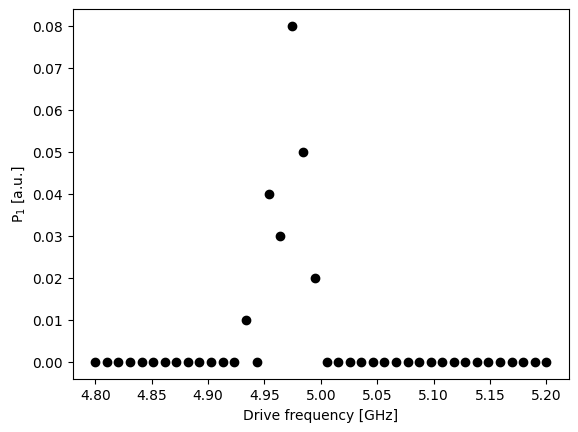

In [5]:
#########################################
# Experiment parameters
#########################################
duration            = 128; 
pulse_amp           = 0.175;
min_freq            = 4.8e9; 
max_freq            = 5.2e9; 
num_points          = 40; 
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
freq_vec    = np.linspace(min_freq,max_freq,num_points); 
freq        = Parameter('freq')
with pulse.build(default_alignment='sequential') as sweep_sched:
    pulse.set_frequency(freq,pulse.DriveChannel(0)); 
    pulse.play(pulse.Constant(duration,
                                pulse_amp,
                                name="Excitation Pulse"),
                                pulse.DriveChannel(0)); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
sweep_schedules = [sweep_sched.assign_parameters({freq: a}, inplace=False) for a in freq_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(sweep_schedules,
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
results = job.result()

#########################################
# P1 computation
#########################################
sweep_values = []
for i in range(len(results.get_counts())):
    try:
        p1 = results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    sweep_values.append(p1/num_shots_per_point)

#########################################
# Graphics
#########################################
plt.xlabel("Drive frequency [GHz]")
plt.ylabel("P$_1$ [a.u.]")
plt.scatter(freq_vec/1e9, sweep_values, color='black')
plt.show()

Notice that with the duration/drive amplitude combination we chose, the excitation is typically weak ($P_1$ < 0.1). We can slightly increase the pulse amplitude to get a clearer figure: 

In [ ]:
#########################################
# Experiment parameters
#########################################
duration            = 128; 
pulse_amp           = 0.35;
min_freq            = 4.8e9; 
max_freq            = 5.2e9; 
num_points          = 40; 
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
freq_vec    = np.linspace(min_freq,max_freq,num_points); 
freq        = Parameter('freq')
with pulse.build(default_alignment='sequential') as sweep_sched:
    pulse.set_frequency(freq,pulse.DriveChannel(0)); 
    pulse.play(pulse.Constant(duration,pulse_amp,name="Excitation Pulse"),pulse.DriveChannel(0)); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
sweep_schedules = [sweep_sched.assign_parameters({freq: a}, inplace=False) for a in freq_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(sweep_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
results = job.result()

#########################################
# P1 computation
#########################################
sweep_values = []
for i in range(len(results.get_counts())):
    try:
        p1 = results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    sweep_values.append(p1/num_shots_per_point)

Results are plotted and fitted with a Lorentzian curve: 
\begin{align}
\mathcal{L}(f) = \frac{A}{\pi} \frac{B}{(f-f_0)^2 + B^2} + C
\end{align}
where $f_0$ will be the estimated qubit frequency:

Estimated qubit frequency: 4.9757 GHz


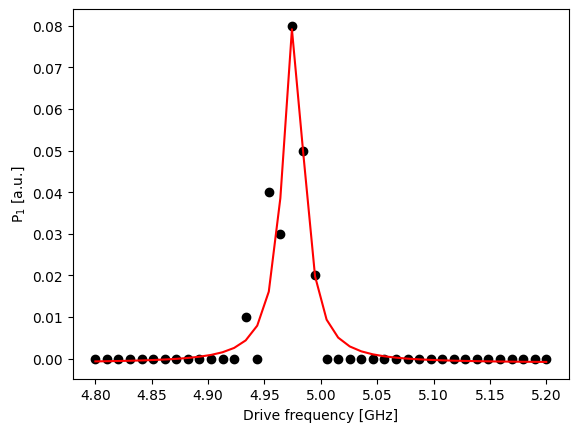

In [6]:
#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(freq_vec/1e9,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.94, 0.01, -0.001] # initial parameters for curve_fit
                                )
rough_f = fit_params[1] * 1e9; 
print(f"Estimated qubit frequency: {rough_f/1e9:.4f} GHz")

#########################################
# Graphics
#########################################
plt.xlabel("Drive frequency [GHz]")
plt.ylabel("P$_1$ [a.u.]")
plt.scatter(freq_vec/1e9, sweep_values, color='black')
plt.plot(freq_vec/1e9, y_fit, color='red')
plt.show()

The higher probability gives us a higher confidence on the estimated qubit frequency as we move away from the noise floor. Since our frequency sweep used a 10 MHz frequency step, we can now be confident that the real qubit frequency will lie in a less-than-10 MHz neighborhood of this estimated frequency. Detuning effects will thus have time constants in the order of (at minimum) 1/10 MHz = 100 ns. As long as we keep our experiments shorter than 100 ns, we can be confident that our experiments will be mostly unaffected by detuning. We can thus perform a first Rabi calibration to obtain the $\pi$-amplitude: 

In [7]:
#########################################
# Experiment parameters
#########################################
num_points          = 50;
duration            = 128; 
drive_amp_min       = 0;
drive_amp_max       = 1.;
num_shots_per_point = 100;

#########################################
# Parametric schedule creation
#########################################
drive_amps  = np.linspace(drive_amp_min, drive_amp_max, num_points)
drive_amp   = Parameter('drive_amp')
with pulse.build(default_alignment='sequential') as rabi_sched:
    pulse.set_frequency(rough_f,pulse.DriveChannel(0)); 
    pulse.play(pulse.Constant(duration,
                                drive_amp,
                                name="Rabi Pulse"),
                                pulse.DriveChannel(0)); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

#########################################
# Backend simulation
#########################################
job = backend.run(rabi_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
rabi_results = job.result()

As usual, we plot and fit the results with a sinusoidal shape: 

Pi Amplitude = 0.8509630893475784
Pi/2 Amplitude = 0.4254815446737892


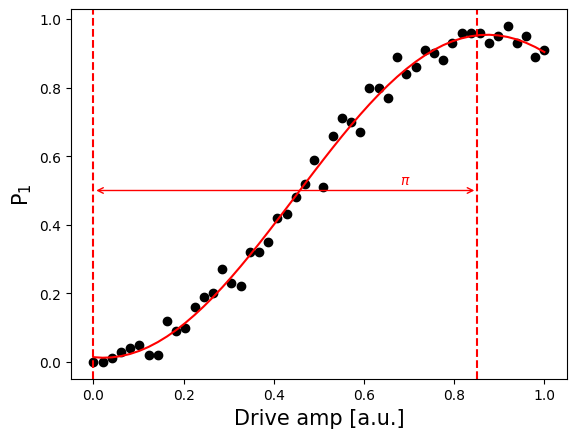

In [8]:
#########################################
# P1 computation
#########################################
rabi_values = []
for i in range(num_points):
    try:
        p1 = rabi_results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rabi_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                 [0.5, -0.5, 2, 0])
pi_amp = abs(fit_params[2] / 2)
print(f"Pi Amplitude = {pi_amp}")
print(f"Pi/2 Amplitude = {pi_amp/2}")

#########################################
# Graphics
#########################################
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.annotate("", xy=(0, 0.5), xytext=(pi_amp,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp * .8, 0.52), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

We can create shorthands for an X90 and a $\pi$ pulse:

In [ ]:
#########################################
# X-90 pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pihalf:
    pulse.play(pulse.Constant(duration,pi_amp/2,name="$\pi/2$-Rabi Pulse"),pulse.DriveChannel(0)); 

#########################################
# X pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pi:
    pulse.play(pulse.Constant(duration,pi_amp,name="$\pi$-Rabi Pulse"),pulse.DriveChannel(0)); 

### Drive frequency fine-tuning: Ramsey experiment <a class="anchor" id="ramsey-experiment"></a>
Rabi pulses calibrated using the _coarse_ procedure can now be used for the second step of the frequency tuning procedure, _i.e._ the _fine_ tuning. Fine tuning is performed by means of the Ramsey experiment, comprising two $\pi/2$-pulses separated by an increasing delay. Owing to the qubit's precession due to detuning, the overall probability of measuring the $|1\rangle$ state will depend on the delay being in-phase with the detuning between the drive field and the qubit's frequency. The typical Ramsey experiment $P_1$ output shows oscillations at a frequency corresponding to the drive-qubit detuning. 

Owing to the structure of the frequency sweep we performed, the current detuning between the drive field and the qubit can lie anywhere in the [0,10 MHz] interval. Small detunings can therefore lead to potentially long delays required to observe oscillations, triggering relaxation and dephasing effects which may alter the experiment and destroy the quantum state. As such, we add a forced detuning of 10 MHz on the drive in order to accelerate the Ramsey oscillations.

In [ ]:
#########################################
# Experiment parameters
#########################################
num_points          = 20;       # Number of delays to test
delay_dt            = 64;       # Delay increment between schedules [dt]
detune              = 10e6;     # Forced detuning [Hz]
num_shots_per_point = 1000; 

#########################################
# Parametric schedule construction
#########################################
delay = Parameter('delay')
with pulse.build(default_alignment='sequential') as rams_sched:
    pulse.set_frequency(rough_f+detune,pulse.DriveChannel(0)); 
    pulse.call(x_pihalf);
    pulse.delay(delay,pulse.DriveChannel(0)); 
    pulse.call(x_pihalf); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
delay_vec       = np.linspace(0,(num_points-1),num_points)*delay_dt;
rams_schedules  = [rams_sched.assign_parameters({delay: a}, inplace=False) for a in delay_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(rams_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
results = job.result()

We can plot the probability of measuring the $|1\rangle$ state to estimate the Ramsey frequency, which includes the forced detuning and the effective (natural) detuning: 

In [ ]:
#########################################
# P1 computation
#########################################
rams_values = []
for i in range(num_points):
    try:
        p1 = results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rams_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
delay_times         = delay_vec*dt; 
fit_params, y_fit   = fit_function(delay_times,
                                   rams_values,
                                   lambda x, A, B, delay_period, phi: (A*np.sin(2*np.pi*x/delay_period - phi) + B),
                                   [0.5, -0.5, 100e-9, 0])
delay_period    = fit_params[2];
ramsey_f        = 1/delay_period; 
qubit_f         = rough_f - (ramsey_f - detune); 
print(f"Ramsey frequency (natural + forced): {ramsey_f/1e6:.3f} MHz")
print(f"Ramsey frequency (natural): {(ramsey_f-detune)/1e6:.3f} MHz")
print(f"Updated drive frequency: {(-ramsey_f+rough_f+detune)/1e9:.6f} GHz")
print(f"Detuning: {(qubit_f-omega/2/np.pi)/1e3:.3f} kHz")

#########################################
# Graphics
#########################################
plt.scatter(delay_times/1e-9, rams_values, color='black')
plt.plot(delay_times/1e-9, y_fit, color='red')
plt.axvline((delay_times[0] + delay_period/2)/1e-9, color='red', linestyle='--')
plt.axvline((delay_times[0])/1e-9, color='red', linestyle='--')
plt.annotate("", xy=(delay_times[0]/1e-9, 0.5), xytext=((delay_times[0] + delay_period/2)/1e-9,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=((delay_times[0] + delay_period/4)/1e-9, 0.52), color='red')
plt.xlabel("Delay time [ns]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

Notice how the estimated frequency now matches the qubit's frequency to within the kHz range, effectively providing detuning times in the order of ~ms, which are typically far larger than dissipative time constants.

### Rabi pulse fine-tuning

Using the updated frequency, we can now fine-tune also the Rabi pulses: 

In [ ]:
#########################################
# Experiment parameters
#########################################
num_points          = 50
duration            = 128; 
drive_amp_min       = 0
drive_amp_max       = 1.
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
drive_amp = Parameter('drive_amp')
with pulse.build() as rabi_sched:
    with pulse.align_sequential():
        pulse.set_frequency(qubit_f,pulse.DriveChannel(0)); 
        pulse.play(pulse.Constant(duration,
                                  drive_amp,
                                  name="Rabi Pulse"),
                   pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_points)
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

#########################################
# Backend simulation
#########################################
job = backend.run(rabi_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
rabi_results = job.result()

#########################################
# P1 computation
#########################################
rabi_values = []
for i in range(num_points):
    try:
        p1 = rabi_results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rabi_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                 [0.5, -0.5, 2, 0])
pi_amp = abs(fit_params[2] / 2)
print(f"Pi Amplitude = {pi_amp}")
print(f"Pi/2 Amplitude = {pi_amp/2}")

#########################################
# Graphics
#########################################
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.annotate("", xy=(0, 0.5), xytext=(pi_amp,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp * .8, 0.52), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

Similarly, we update our shorthands for the $\pi/2$ and $\pi$ pulses: 

In [ ]:
#########################################
# X-90 pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pihalf:
    pulse.play(pulse.Constant(duration,pi_amp/2,name="$\pi/2$-Rabi Pulse"),pulse.DriveChannel(0)); 

#########################################
# X pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pi:
    pulse.play(pulse.Constant(duration,pi_amp,name="$\pi$-Rabi Pulse"),pulse.DriveChannel(0)); 

## $T_1$ characterization: inversion recovery <a class="anchor" id="inversion-recovery"></a>
The introduction of energy relaxation effects leads to the state collapsing to $|0\rangle$ after a finite time after excitation to the $|1\rangle$ state, due to the qubit's energy dissipating. The energy relaxation is typically measured using the $T_1$ metric, corresponding to the decay time constant of the excited state relaxation. To measure the $T_1$, we perform an _inversion recovery_ experiment by first exciting the qubit to the $|1\rangle$ state using a calibrated $\pi$-pulse, and then measuring the qubit state after increasing delays. 

In [ ]:
#########################################
# Experiment parameters
#########################################
num_points          = 10;       # Number of delays to test
delay_dt            = 131072;   # Delay increment between schedules [dt]
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
delay = Parameter('delay')
with pulse.build(default_alignment='sequential') as t1_sched:
        pulse.set_frequency(qubit_f,pulse.DriveChannel(0)); 
        pulse.call(x_pi); 
        pulse.delay(delay,pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
delay_vec   = np.linspace(0,(num_points-1),num_points)*delay_dt; 
t1_scheds   = [t1_sched.assign_parameters({delay: a}, inplace=False) for a in delay_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(t1_scheds, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
t1_results = job.result()

We fit the results with an exponential decay: 
\begin{align}
E(t) = Ae^{-\frac{x}{T}}+C
\end{align}
where $T$ corresponds to the $T_1$ relaxation time. 

In [ ]:
#########################################
# P1 computation
#########################################
t1_values = []
for i in range(num_points):
    try:
        p1 = t1_results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    t1_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(delay_vec*dt,
                                 t1_values, 
                                 lambda x, T, A, C: A*np.exp(-x/T)+C,
                                 [10e-6,1,0])
T1 = fit_params[0];
print(f"T1 = {T1/1e-6:.3f} us")

#########################################
# Graphics
#########################################
plt.scatter(delay_vec*dt/1e-6, t1_values, color='black')
plt.plot(delay_vec*dt/1e-6, y_fit, color='red')
plt.xlabel("Delay [$\mu$s]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

## T2 characterization: Hahn echoes <a class="anchor" id="hahn-echoes"></a>
The second dissipative effect we consider is dephasing, which is typically a result of the qubit's frequency broadening around its center frequency, either due to nonuniformities or band widening effects. Dephasing is typically characterized by the $T_2$ metric, namely the time after which a quantum superposition of $|0\rangle$ and $|1\rangle$ with definite phase (_e.g._ a $|+\rangle$ state) becomes a classical mixture of $|+\rangle$ and $|-\rangle$ states. $T_2$ is typically measured performing Hahn echoes experiments, consisting of:
- a first $\pi/2$-pulse to bring the state in the $xy$-plane;
- a delay of time $t_0$, during which the qubit dephases;
- a $\pi$-pulse to reverse the qubit phase in the $xy$ plane;
- a delay of time $t_0$, during which the qubit rephases;
- an echo $\pi/2$-pulse to bring the state back to $|0\rangle$. 

In [ ]:
#########################################
# Experiment parameters
#########################################
num_points          = 15;
delay_dt            = 81920; 
num_shots_per_point = 100;

#########################################
# Experiment parameters
#########################################
delay = Parameter('delay')
with pulse.build(default_alignment='sequential') as t2_sched:
    pulse.set_frequency(qubit_f,pulse.DriveChannel(0)); 
    pulse.call(x_pihalf);     

    pulse.delay(delay,pulse.DriveChannel(0)); 
    pulse.call(x_pi); 
    pulse.delay(delay,pulse.DriveChannel(0)); 

    pulse.call(x_pihalf); 
    pulse.acquire(1,0,pulse.MemorySlot(0));
delay_vec   = np.linspace(0,num_points-1,num_points)*delay_dt; 
t2_scheds = [t2_sched.assign_parameters({delay: a}, inplace=False) for a in delay_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(t2_scheds, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
t2_results = job.result()

We can similarly fit the resulting curve with an exponential decay. Notice that, since the state relaxes towards a classical mixture of $|+\rangle$ and $|-\rangle$, the probability of measuring $|0\rangle$ at large delay times approaches 0.5:
\begin{align}
E(t) = Ae^{-\frac{x}{T}}+C
\end{align}

In [ ]:
#########################################
# P0 computation
#########################################
t2_values = []
for i in range(len(delay_vec)):
    try:
        p0 = t2_results.get_counts(i)['0'];
    except KeyError:
        p0 = 0; 
    t2_values.append(p0/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(delay_vec*dt,
                                 t2_values, 
                                 lambda x, T, A, C: A*np.exp(-x/T)+C,
                                 [10e-6,0.5,0.5])
T2 = fit_params[0]; 
print(f"T2 = {T2/1e-6} us")

#########################################
# Graphics
#########################################
plt.scatter(delay_vec*dt/1e-6, t2_values, color='black')
plt.plot(delay_vec*dt/1e-6, y_fit, color='red')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel("X90-$\pi$ delay [$\mu$s]", fontsize=15)
plt.ylabel("P$_0$", fontsize=15)
plt.ylim([0,1]);
plt.show()